### Created by: Anthony D. Cho
### Last update: 24.12.2021

**Subject**: Classification (CNN, data augmentation - keras, tensorflow) - Covid19

### Libraries dependencies

In [1]:
import os
import matplotlib.pyplot as plt
%matplotlib inline

from time import time
from numpy import argmax

from sklearn.metrics import confusion_matrix, classification_report

## Keras tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import Adam

### Customized function

In [2]:
def plot_history(history, width=12, height=6):
  """
  DESCRIPTION:
    History performance of the keras model
  
  INPUT:
    @param history: history of performance of fitted model
    @type history: tensorflow.python.keras.callbacks.History

  OUTPUT:
    A graphic
  """

  ## Metrics keys stored in tensorflow object
  keys = list(history.history.keys())

  ## Number of epoch used for fit the model
  epoch = range(1, len(history.epoch) +1)

  ## Check if validation set was used.
  withValidation = False
  for key in keys:
    if 'val' in key:
      withValidation = True

  ## Number of metrics 
  nMetrics = len(keys)
  if withValidation:
    nMetrics = nMetrics//2

  ## Plot-space instance
  plt.figure(figsize=(width, height))

  for i in range(nMetrics):
    plt.subplot(nMetrics, 1, i+1)

    ## Plot (train) metric value
    labelMetric = keys[i]
    metric = history.history[keys[i]]
    plt.plot(epoch, metric, 'o-', label=labelMetric)

    if withValidation:
      ## Plot (validation) metric value
      labelMetricVal = keys[i+nMetrics]
      metricVal = history.history[keys[i+nMetrics]]
      plt.plot(epoch, metricVal, 'o-', label=labelMetricVal)

    plt.xlim(epoch[0], epoch[-1])
    plt.legend()
    plt.grid()

  plt.xlabel('Epoch')
  plt.show()

**Data source:**

[Covid-19](https://www.kaggle.com/pranavraikokte/covid19-image-dataset) (Classification)

In [ ]:
dataset_name = 'Covid19-dataset'

if not os.path.exists("covid19.zip"):
    ## Download files

    !wget https://github.com/adoc-box/Datasets/raw/main/covid19_small.zip
    !wget https://github.com/adoc-box/Datasets/raw/main/covid19_small.z01
    !wget https://github.com/adoc-box/Datasets/raw/main/covid19_small.z02

    ## join files 
    !zip -F covid19_small.zip --out covid19.zip

    ## remove some files
    !rm covid19_small.zip covid19_small.z01 covid19_small.z02

    ## un-compress joined zip file
    !unzip covid19_small.zip
    
else:
    if os.path.exists(dataset_name):
        !rm -r Covid19-dataset
    !unzip covid19.zip

### Image loader generator

In [6]:
## Images PATHs
train_dir = f'{dataset_name}/train/'
test_dir = f'{dataset_name}/test/'

## Image generator instances
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.1)
test_datagen = ImageDataGenerator(rescale=1./255)

## Image conversion size
imgSize = 150

## Generator setting (Train)
train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,

        ## data subset
        subset='training',

        # All images will be resized to (imgSize x imgSize)
        target_size=(imgSize, imgSize),
        batch_size=20,
        
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical')

## Generator setting (Validation)
validation_generator = train_datagen.flow_from_directory(
        train_dir,

        ## data subset
        subset='validation',
        target_size=(imgSize, imgSize),
        batch_size=20,
        shuffle=False,
        class_mode='categorical')

## Generator setting (test)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(imgSize, imgSize),
        batch_size=20,
        shuffle=False,
        class_mode='categorical')

Found 226 images belonging to 3 classes.
Found 25 images belonging to 3 classes.
Found 66 images belonging to 3 classes.


### Model building

In [7]:
## Model design
def get_model():
    """
        CNN Model builder
    """

    ## Model instance

    model = Sequential(name='Covid19')
    model.add(layers.Conv2D(filters=32, 
                            kernel_size=(3, 3), 
                            activation='relu',
                            input_shape=(150, 150, 3),
                            name='Conv2D_01'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2),
                                  name='Pooling_01'))
    model.add(layers.Conv2D(filters=64, 
                            kernel_size=(3, 3), 
                            activation='relu',
                            name='Conv2D_02'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2),
                                  name='Pooling_02'))
    model.add(layers.Conv2D(filters=128, 
                            kernel_size=(3, 3), 
                            activation='relu',
                            name='Conv2D_03'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2),
                                  name='Pooling_03'))
    model.add(layers.Conv2D(filters=128, 
                            kernel_size=(3, 3), 
                            activation='relu',
                            name='Conv2D_04'))
    model.add(layers.MaxPooling2D(pool_size=(2, 2),
                                  name='Pooling_04'))
    model.add(layers.Flatten(name='Flatten'))
    model.add(layers.Dense(units=512, 
                          activation='relu',
                          name='Dense_01'))
    model.add(layers.Dense(units=3, 
                          activation='softmax',
                          name='output'))
    
    ## return model 
    return model

In [8]:
## model instance
model = get_model()

model.summary()

Model: "Covid19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D_01 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 Pooling_01 (MaxPooling2D)   (None, 74, 74, 32)        0         
                                                                 
 Conv2D_02 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 Pooling_02 (MaxPooling2D)   (None, 36, 36, 64)        0         
                                                                 
 Conv2D_03 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 Pooling_03 (MaxPooling2D)   (None, 17, 17, 128)       0         
                                                                 
 Conv2D_04 (Conv2D)          (None, 15, 15, 128)       1475

In [9]:
start = time()

## Compiler setting
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=1e-4),
              metrics=['acc'])

## Model fitting
history = model.fit(
      train_generator, 
      #steps_per_epoch=11,  ## <- 226 images / batch size of 20 approx 11
      validation_data=validation_generator,
      #validation_steps=1,  ## <- 25 images / batch size of 20 approx 1
      epochs=80, verbose=1)

timeUp = time()-start
print('\nTime spent[s]: {:.2f}'.format(timeUp))

model.save('CNN_Covid19.h5')

Epoch 1/80
12/12 [==============================] - 23s 1s/step - loss: 1.0915 - acc: 0.4204 - val_loss: 1.0812 - val_acc: 0.4400
Epoch 2/80
12/12 [==============================] - 12s 993ms/step - loss: 1.0625 - acc: 0.4469 - val_loss: 1.0595 - val_acc: 0.4400
Epoch 3/80
12/12 [==============================] - 12s 999ms/step - loss: 1.0266 - acc: 0.5088 - val_loss: 1.0569 - val_acc: 0.5200
Epoch 4/80
12/12 [==============================] - 12s 1s/step - loss: 0.9728 - acc: 0.5752 - val_loss: 0.9584 - val_acc: 0.5600
Epoch 5/80
12/12 [==============================] - 12s 981ms/step - loss: 0.8608 - acc: 0.6814 - val_loss: 0.8996 - val_acc: 0.6000
Epoch 6/80
12/12 [==============================] - 12s 1s/step - loss: 0.7632 - acc: 0.6770 - val_loss: 0.9144 - val_acc: 0.6800
Epoch 7/80
12/12 [==============================] - 12s 991ms/step - loss: 0.7463 - acc: 0.6947 - val_loss: 0.9684 - val_acc: 0.5200
Epoch 8/80
12/12 [==============================] - 13s 1s/step - loss: 0.6110

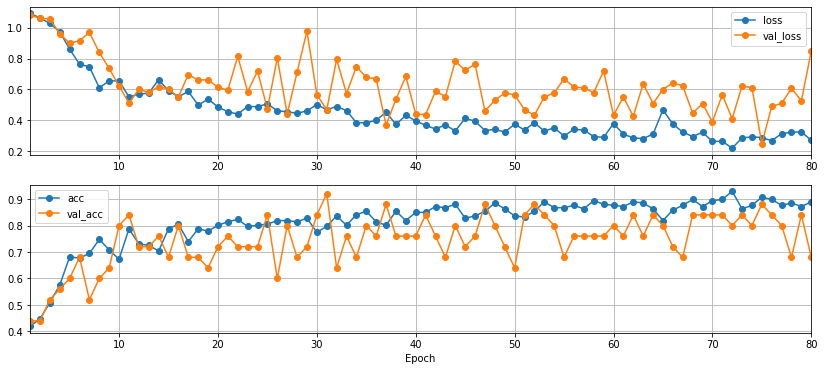

4/4 [==============================] - 2s 425ms/step - loss: 0.2599 - acc: 0.8939
[0.25994589924812317, 0.8939393758773804]


In [10]:
## display performances
plot_history(history, width=14)

## restart test generator index
test_generator.reset()

## evaluate test set in the model
print(model.evaluate(test_generator, 
                     #steps=3
                     ))  ## <- 66 images / batch size of 20 equal 3

## restart test generator index
test_generator.reset()

## Compute prediction using test generator
prediction = model.predict(test_generator)

In [11]:
prediction_decoded = argmax(prediction, axis=1)
prediction_decoded

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1,
       2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2])

In [12]:
y_true = test_generator.labels

In [13]:
y_true.shape, prediction_decoded.shape

((66,), (66,))

In [14]:
## display confusion matrix
print(confusion_matrix(y_true=y_true, y_pred=prediction_decoded))

## display classification report
print(classification_report(y_true=y_true, y_pred=prediction_decoded))

[[26  0  0]
 [ 0 14  6]
 [ 0  1 19]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        26
           1       0.93      0.70      0.80        20
           2       0.76      0.95      0.84        20

    accuracy                           0.89        66
   macro avg       0.90      0.88      0.88        66
weighted avg       0.91      0.89      0.89        66



In [15]:
test_generator.class_indices

{'Covid': 0, 'Normal': 1, 'Viral Pneumonia': 2}

## Best model

Looking into the performance charts, it seems to stabilize (kind of overfit) starting at epoch 31.

In [16]:
## Restart all generators
train_generator.reset()
test_generator.reset()

In [18]:
## Model instance
model = get_model()

model.summary()

Model: "Covid19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D_01 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 Pooling_01 (MaxPooling2D)   (None, 74, 74, 32)        0         
                                                                 
 Conv2D_02 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 Pooling_02 (MaxPooling2D)   (None, 36, 36, 64)        0         
                                                                 
 Conv2D_03 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 Pooling_03 (MaxPooling2D)   (None, 17, 17, 128)       0         
                                                                 
 Conv2D_04 (Conv2D)          (None, 15, 15, 128)       1475

In [19]:
start = time()

## Compiler setting
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=1e-4),
              metrics=['acc'])

## Model fitting
history = model.fit(
      train_generator, 
      #steps_per_epoch=115,  ## <- 226 images / batch size of 20 approx 13
      epochs=31, verbose=1)

timeUp = time()-start
print('\nTime spent[s]: {:.2f}'.format(timeUp))

model.save('CNN_Covid19.h5')

Epoch 1/31
12/12 [==============================] - 11s 850ms/step - loss: 1.0811 - acc: 0.4071
Epoch 2/31
12/12 [==============================] - 10s 849ms/step - loss: 1.0220 - acc: 0.4690
Epoch 3/31
12/12 [==============================] - 10s 837ms/step - loss: 0.9466 - acc: 0.5885
Epoch 4/31
12/12 [==============================] - 10s 851ms/step - loss: 0.8328 - acc: 0.6726
Epoch 5/31
12/12 [==============================] - 19s 2s/step - loss: 0.8258 - acc: 0.6504
Epoch 6/31
12/12 [==============================] - 10s 817ms/step - loss: 0.7711 - acc: 0.6327
Epoch 7/31
12/12 [==============================] - 15s 1s/step - loss: 0.7938 - acc: 0.6150
Epoch 8/31
12/12 [==============================] - 11s 867ms/step - loss: 0.6541 - acc: 0.7301
Epoch 9/31
12/12 [==============================] - 12s 954ms/step - loss: 0.6089 - acc: 0.7611
Epoch 10/31
12/12 [==============================] - 10s 845ms/step - loss: 0.6381 - acc: 0.7434
Epoch 11/31
12/12 [==========================

In [20]:
## restart test generator index
test_generator.reset()

## evaluate test set in the model
print(model.evaluate(test_generator, 
                     #steps=3
                     ))  ## <- 66 images / batch size of 20 equal 3

## restart test generator index
test_generator.reset()

## Compute prediction using test generator
prediction = model.predict(test_generator)

4/4 [==============================] - 2s 438ms/step - loss: 0.3500 - acc: 0.8788
[0.35002267360687256, 0.8787878751754761]


In [21]:
prediction_decoded = argmax(prediction, axis=1)
y_true = test_generator.labels

In [22]:
## display confusion matrix
print(confusion_matrix(y_true=y_true, y_pred=prediction_decoded))

## display classification report
print(classification_report(y_true=y_true, y_pred=prediction_decoded))

[[25  0  1]
 [ 0 20  0]
 [ 0  7 13]]
              precision    recall  f1-score   support

           0       1.00      0.96      0.98        26
           1       0.74      1.00      0.85        20
           2       0.93      0.65      0.76        20

    accuracy                           0.88        66
   macro avg       0.89      0.87      0.87        66
weighted avg       0.90      0.88      0.88        66

